In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

plt.style.use("../Mods/mystyle.mplstyle")

# Linear Fit

In [93]:
def retta(x: np.ndarray, m, q):
    return m * x + q


def LinReg(X: np.ndarray, Y: np.ndarray):
    params, cov = scipy.optimize.curve_fit(retta, X, Y, p0=[1, 0])

    std_dev = np.sqrt(np.diag(cov))

    return params, std_dev

# Get k from static method

In [94]:
with open("Data/k statico forzante 29-05-24.csv") as file:
    df = pd.read_csv(file, decimal=",", delimiter=";")
    df.info()

mean_pos = [df[f"Position (mm) Run #{i+1}"].mean() for i in range(df.shape[1] // 2)]
# masse = [50.37, 70.24, 89.86]
masse = [88.85, 70.24, 50.36]

params, std_err = LinReg(mean_pos, masse)

k_molla = -params[0] * 9.805  # ? che valore usare per g?
err_k_molla = std_err[0] * 9.805

print(f"Cost. elastica molla: {k_molla: 5.3f} ±{err_k_molla: 5.3f}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4644 entries, 0 to 4643
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Time (s) Run #1       4620 non-null   float64
 1   Position (mm) Run #1  4620 non-null   float64
 2   Time (s) Run #2       4644 non-null   float64
 3   Position (mm) Run #2  4644 non-null   float64
 4   Time (s) Run #3       4634 non-null   float64
 5   Position (mm) Run #3  4634 non-null   float64
dtypes: float64(6)
memory usage: 217.8 KB
Cost. elastica molla:  3.066 ± 0.046


# Calculate damping $\gamma$

In [95]:
def dampedsine(x: np.ndarray, A, gamma, omega, phi, h):
    return A * np.exp(-gamma * x) * np.cos(omega * x + phi) + h


def FitDampedSine(X: np.ndarray, Y: np.ndarray):
    params, cov = scipy.optimize.curve_fit(dampedsine, X, Y, p0=[100, 0.001, 1, 0, 130])
    std_dev = np.sqrt(np.diag(cov))

    return params, std_dev

gamma: 0.06714 ±0.00014


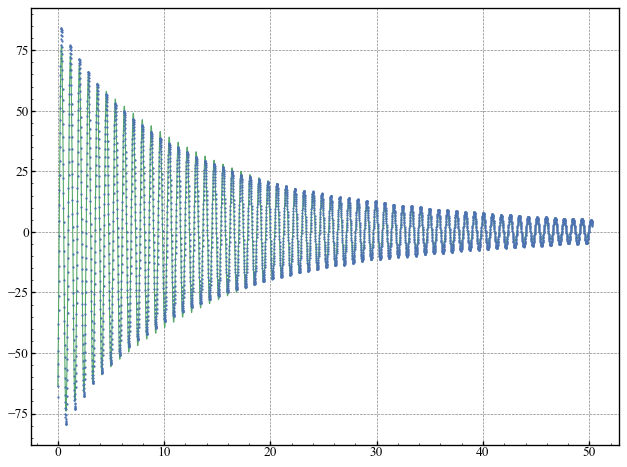

In [96]:
massa = masse[-1]

with open("Data/stima tempo caratteristico.csv") as file:
    df = pd.read_csv(file, decimal=",", delimiter=";")

    Y = df.iloc[:, 0].to_numpy()
    X = np.arange(len(Y)) / 100

    params, std_dev = FitDampedSine(X, Y)

    plt.errorbar(X, Y, yerr=0.2, fmt=".")
    plt.plot(X, dampedsine(X, *params))

    gamma = params[1]

    print(f"gamma: {params[1]:.5f} ±{std_dev[1]:.5f}")

# Calculate $\omega$ and $\omega_0$

In [97]:
massa_usata = 50.37  # ! correggere i decimali
massa_molla = 15.48  # ! correggere i decimali
massa_tot = (massa_usata + massa_molla / 3) / 1000

omega_0 = np.sqrt(k_molla / massa_tot)
err_omega_0 = 0  # ! bisogna poi calcolare l'incertezza su omega

print(f"omega_0: {omega_0: 5.3f} ±{err_omega_0: 5.3f}")

omega = np.sqrt(np.square(omega_0) - np.square(gamma))
err_omega = 0  # ! bisogna poi calcolare l'incertezza su omega

print(f"omega: {omega: 5.3f} ±{err_omega: 5.3f}")

omega_0:  7.431 ± 0.000
omega:  7.430 ± 0.000


# Get half width of lorentzian and frequencies

In [98]:
half_w_omega = 2 * np.sqrt(3) * gamma
half_w_freq = half_w_omega / (2 * np.pi)

mid_freq = omega / (2 * np.pi)

frequencies = [mid_freq, mid_freq - half_w_freq / 2, mid_freq + half_w_freq / 2]
frequencies.extend([mid_freq - i * half_w_freq / 5 for i in range(1, 6)])
frequencies.extend([mid_freq + i * half_w_freq / 5 for i in range(1, 6)])
frequencies.extend([1.186, 1.180, 1.172, 1.194])  # misure aggiunte dopo

frequencies = np.array(frequencies)

print(f"Frequencies to use: {[f'{freq:.3f}' for freq in frequencies]}")

Frequencies to use: ['1.183', '1.164', '1.201', '1.175', '1.168', '1.160', '1.153', '1.146', '1.190', '1.197', '1.205', '1.212', '1.220', '1.186', '1.180', '1.172', '1.194']


la frequenza 1.175 c'è un errore tra 70 e 80 secondi

# Make the lorentzian

Misura (ν = 1.183): mean_pos=0.830, pos_amp=37.201, neg_amp=37.165
Misura (ν = 1.164): mean_pos=0.264, pos_amp=18.800, neg_amp=18.740
Misura (ν = 1.201): mean_pos=0.180, pos_amp=22.827, neg_amp=22.791
Misura (ν = 1.175): mean_pos=0.477, pos_amp=30.794, neg_amp=30.880
Misura (ν = 1.168): mean_pos=0.379, pos_amp=22.162, neg_amp=22.255
Misura (ν = 1.160): mean_pos=0.452, pos_amp=16.492, neg_amp=16.597
Misura (ν = 1.153): mean_pos=0.305, pos_amp=13.087, neg_amp=13.117
Misura (ν = 1.146): mean_pos=0.172, pos_amp=11.024, neg_amp=11.031
Misura (ν = 1.190): mean_pos=0.089, pos_amp=34.612, neg_amp=34.566
Misura (ν = 1.197): mean_pos=0.098, pos_amp=27.171, neg_amp=27.186
Misura (ν = 1.205): mean_pos=0.044, pos_amp=19.446, neg_amp=19.392
Misura (ν = 1.212): mean_pos=0.293, pos_amp=15.204, neg_amp=15.272
Misura (ν = 1.220): mean_pos=-0.018, pos_amp=11.877, neg_amp=11.831
Misura (ν = 1.186): mean_pos=-0.080, pos_amp=37.692, neg_amp=37.592
Misura (ν = 1.180): mean_pos=0.199, pos_amp=36.498, neg_amp=

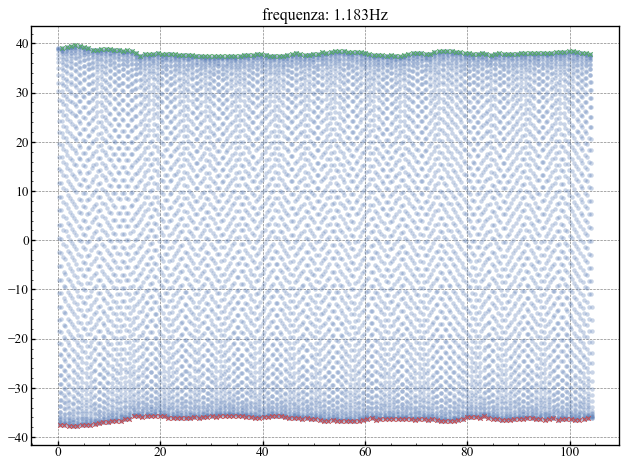

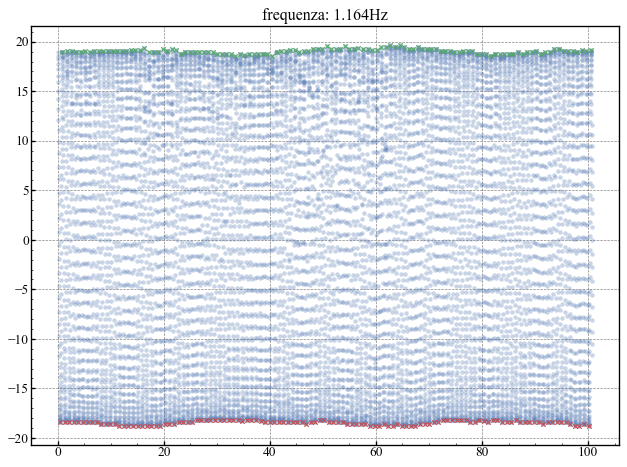

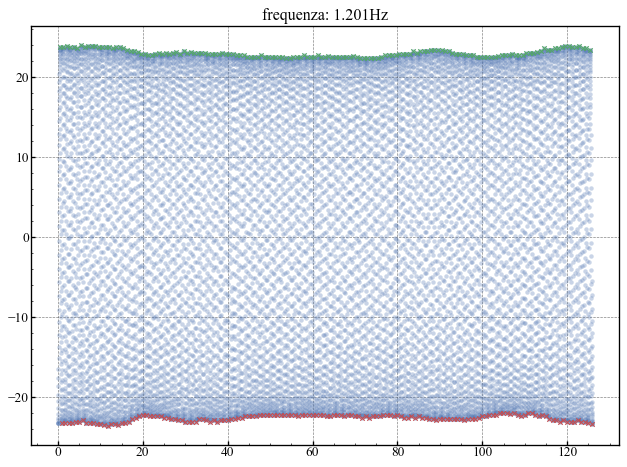

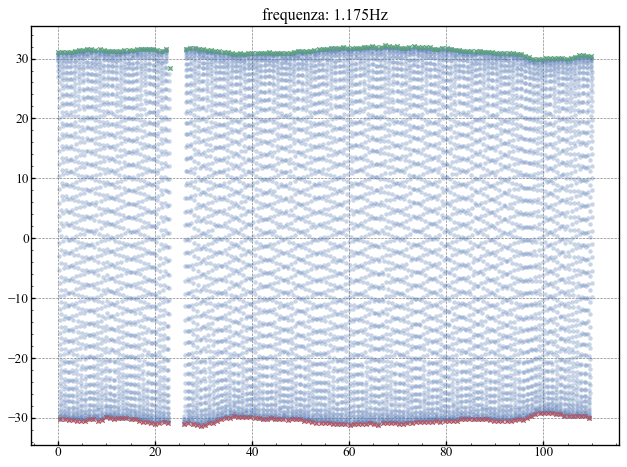

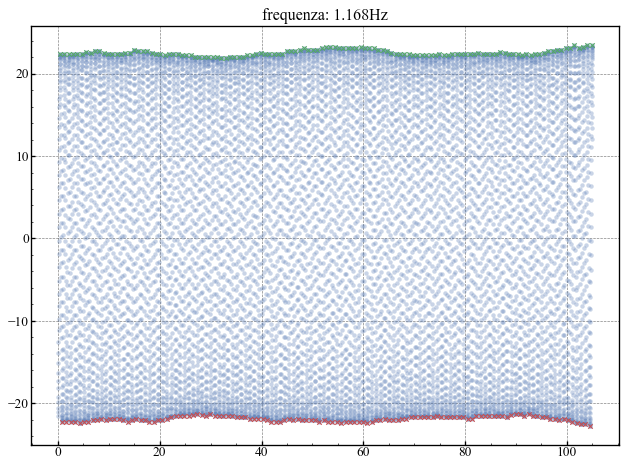

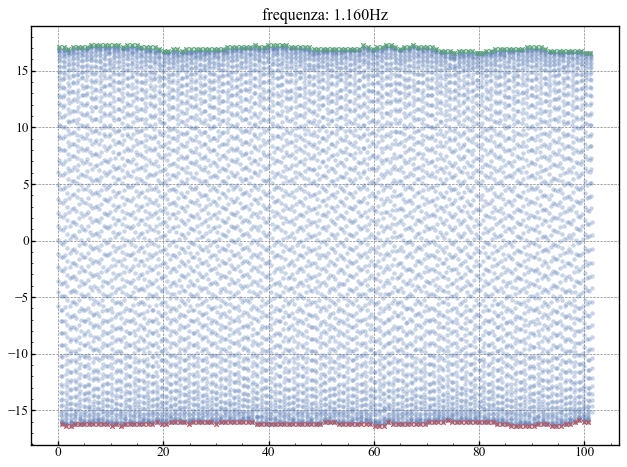

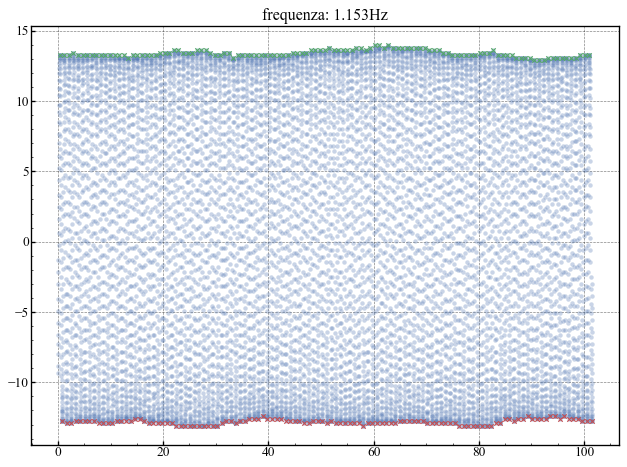

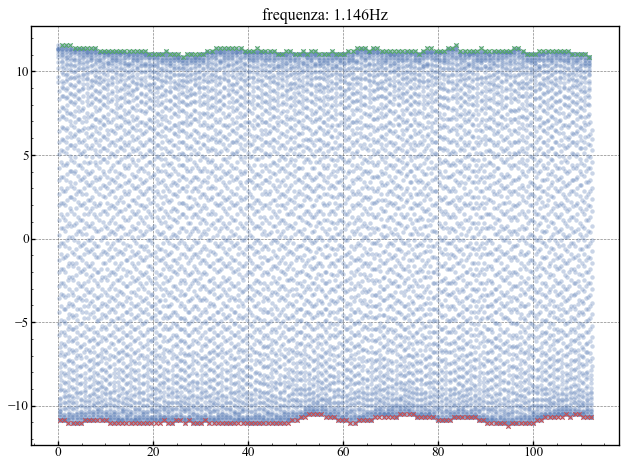

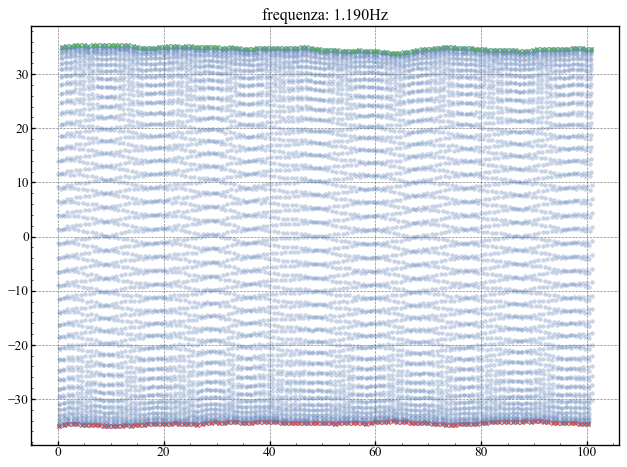

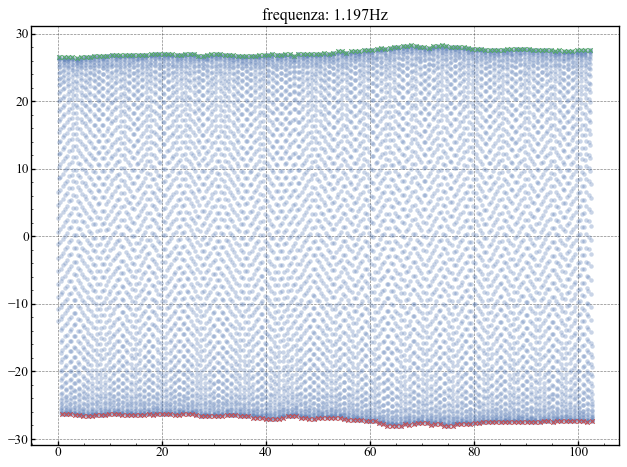

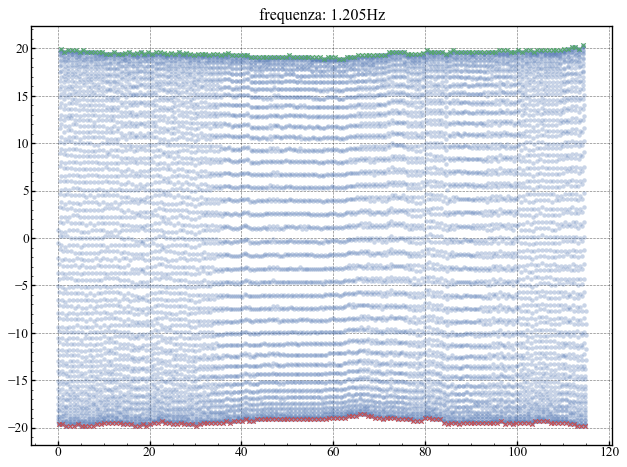

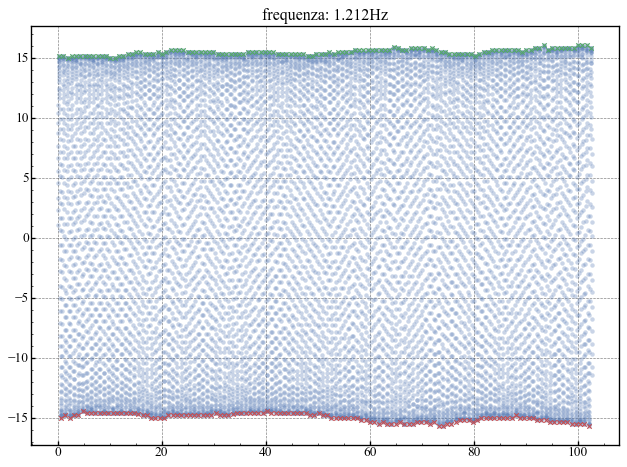

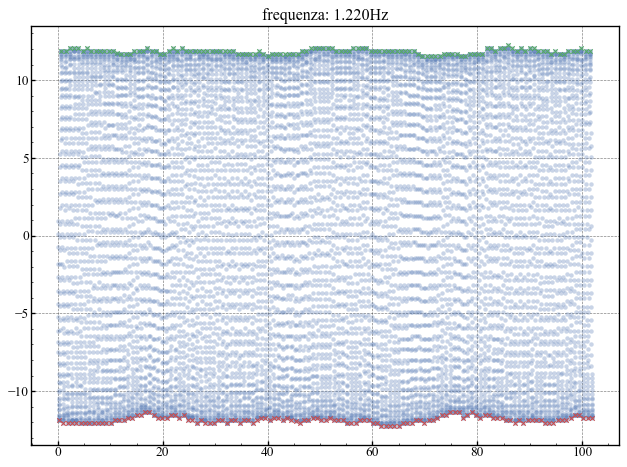

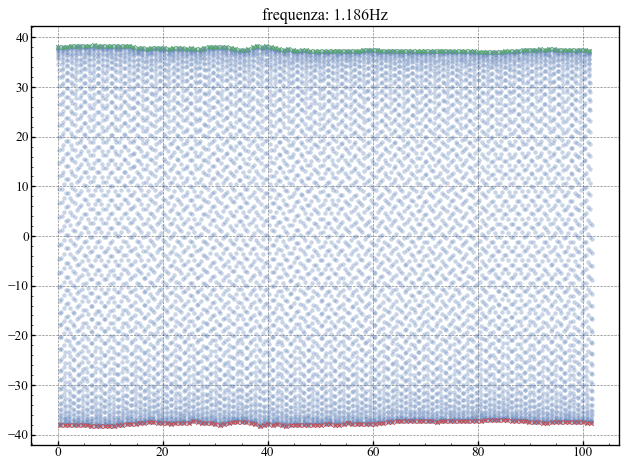

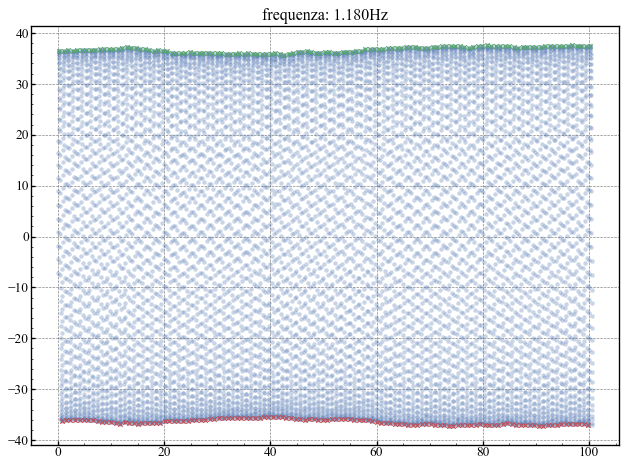

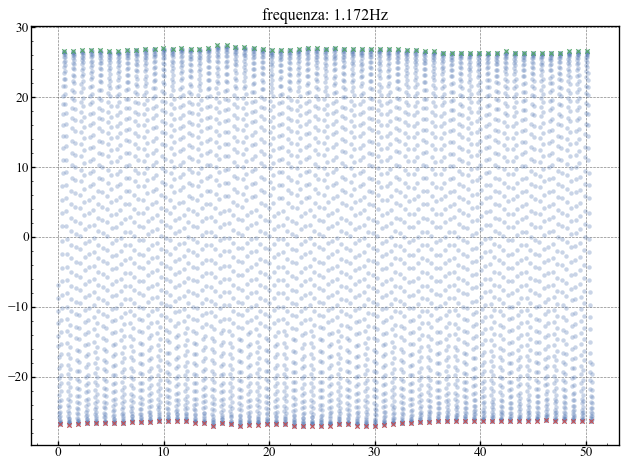

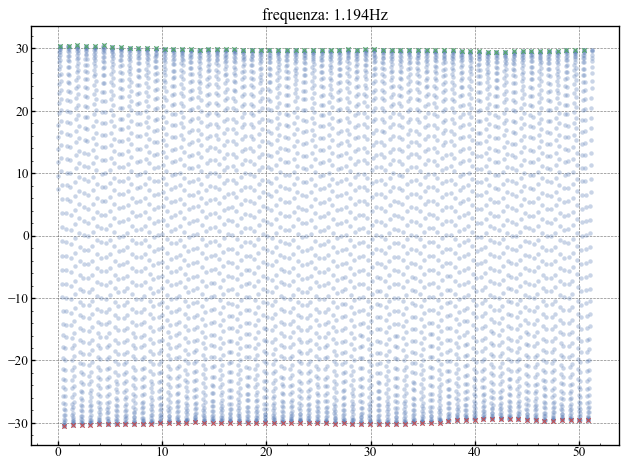

In [99]:
with open("Data/oscillazioni lorentziana complete.csv") as file:
    df = pd.read_csv(file, decimal=",", delimiter=";")

# ! come faccio a non sovrastimare l'ampiezza delle oscillazioni?

# ? magari fare la media di n_amps e p_amps è meglio?
p_amps = []
n_amps = []
for i in range(df.shape[1]):
    fig, ax = plt.subplots()
    Y = df.iloc[5000:, i].dropna().to_numpy()
    X = np.arange(len(Y)) / 100

    if i == 3:
        X = np.concatenate((X[:2300], X[2600:]))
        Y = np.concatenate((Y[:2300], Y[2600:]))

    mean_position = np.mean(Y)
    p_pks, _ = scipy.signal.find_peaks(Y, distance=20, prominence=1, height=(10, 50))
    n_pks, _ = scipy.signal.find_peaks(-Y, distance=20, prominence=1, height=(10, 50))

    p_amp = np.mean(Y[p_pks]) - mean_position
    n_amp = mean_position - np.mean(Y[n_pks])

    print(
        f"Misura (ν = {frequencies[i]:.3f}): mean_pos={mean_position:.3f}, pos_amp={p_amp:.3f}, neg_amp={n_amp:.3f}"
    )
    # ! Come calcolo i relativi errori?

    p_amps.append(p_amp)
    n_amps.append(n_amp)

    ax.set_title(f"frequenza: {frequencies[i]:.3f}Hz")
    ax.scatter(X, Y, alpha=0.3)
    ax.scatter(X[p_pks], Y[p_pks], marker="x")
    ax.scatter(X[n_pks], Y[n_pks], marker="x")

p_amps = np.array(p_amps)
n_amps = np.array(n_amps)

## Show lorentzian

[1.18454358 0.04382694 2.53872442]


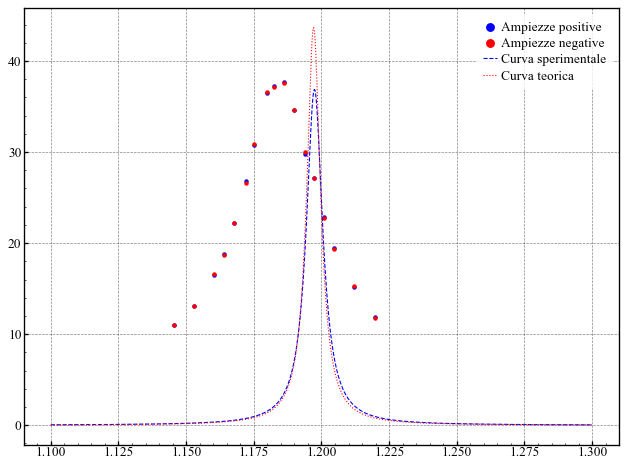

In [100]:
fig, ax = plt.subplots()
ax.scatter(frequencies, p_amps, c="b")
ax.scatter(frequencies, n_amps, c="r")


def lorentzian(x: np.ndarray, c, w, h):
    # c: center, w: width, h: height
    return h * (0.5 * w / ((x - c) ** 2 + (0.5 * w) ** 2)) / np.pi


def LorFit(X: np.ndarray, Y: np.ndarray):
    params, cov = scipy.optimize.curve_fit(lorentzian, X, Y, p0=[1.18, 0.05, 40])
    std_dev = np.sqrt(np.diag(cov))
    return params, std_dev


freqs = np.concatenate((frequencies, frequencies))
amps = np.concatenate((p_amps, n_amps))

params, std_dev = LorFit(freqs, amps)

print(params)
# sperimentale
ax.plot(
    np.linspace(1.1, 1.3, 1000),
    lorentzian(np.linspace(1.1, 1.3, 1000), *params),
    ls="--",
    c="b",
)

# teorica
ax.plot(
    np.linspace(1.1, 1.3, 1000),
    lorentzian(np.linspace(1.1, 1.3, 1000), mid_freq, half_w_freq, params[-1]),
    ls=":",
    c="r",
)

ax.legend(
    ["Ampiezze positive", "Ampiezze negative", "Curva sperimentale", "Curva teorica"]
)